In [37]:
import dgl
from dgl.data import FraudDataset

dataset = FraudDataset("yelp")
g = dataset[0]
print(g.etypes)
print(g.ntypes)
print(g.ndata)
print(g.ndata.keys())
print()
print(g.ndata["feature"])


Done loading data from cached files.
['net_rsr', 'net_rtr', 'net_rur']
['review']
{'val_mask': tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'test_mask': tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 1, 1,  ..., 0, 1, 1], dtype=torch.uint8), 'label': tensor([0, 0, 0,  ..., 0, 0, 0]), 'feature': tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        ...,
        [0.0091, 0.3500, 0.4287,  ..., 0.4826, 0.8010, 0.1642],
        [0.0062, 0.0705, 1.0000,  ..., 0.4428, 0.4478, 0.5871],
        [0.0032, 0.3500, 0.4287,  ..., 0.4428, 0.4478, 0.5871]])}
dict_keys(['val_mask', 'test_mask', 'train_mask', 'label', 'feature'])

tensor([[0.0224, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
        [0.0249, 1.0000, 1.0000,  ..., 0.5920, 0.1393, 0.4975],
        [0.0062, 0.0705, 0.4287,  ..., 0.5920, 0.1393, 0.4975],
  

In [38]:
mask = g.ndata["train_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["val_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))

mask = g.ndata["test_mask"].to(bool)
l = {0: 0, 1: 0}

for x in g.ndata["label"][mask].numpy():
    l[x] += 1
print(l, l[0] / (mask.sum()))


{0: 27441, 1: 4726} tensor(0.8531)
{0: 3944, 1: 651} tensor(0.8583)
{0: 7892, 1: 1300} tensor(0.8586)


In [47]:
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import dgl.nn.pytorch as gnn


# class GCN(pl.LightningModule):
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super().__init__()
        self.conv1 = gnn.HeteroGraphConv(
            {
                "net_rsr": gnn.SAGEConv(in_feats, h_feats,'pool'),
                "net_rtr": gnn.SAGEConv(in_feats, h_feats,'pool'),
                "net_rur": gnn.SAGEConv(in_feats, h_feats,'pool'),
            },
            aggregate="sum",
        )
        self.conv2 = gnn.HeteroGraphConv(
            {
                "net_rsr": gnn.SAGEConv(h_feats, num_classes,'pool'),
                "net_rtr": gnn.SAGEConv(h_feats, num_classes,'pool'),
                "net_rur": gnn.SAGEConv(h_feats, num_classes,'pool'),
            },
            aggregate="sum",
        )

        self.conv0 = gnn.HeteroGraphConv(
            {
                "net_rsr": gnn.GraphConv(in_feats, num_classes),
                "net_rtr": gnn.GraphConv(in_feats, num_classes),
                "net_rur": gnn.GraphConv(in_feats, num_classes),
            },
            aggregate="sum",
        )

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h['review'])
        h = self.conv2(g, {'review':h})
        # h  = self.conv0(g,in_feat)
        return h


In [50]:
from torchmetrics import F1Score


def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    f1 = F1Score("binary")

    features = {"review": g.ndata["feature"]}
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"].to(bool)
    val_mask = g.ndata["val_mask"].to(bool)
    test_mask = g.ndata["test_mask"].to(bool)
    for e in range(10_000):
        # Forward
        logits = model(g, features)["review"]

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            # print(
            #     "In epoch {}, acc: {:.3f} loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
            #         e, train_acc, loss, val_acc, best_val_acc, test_acc, best_test_acc
            #     )
            # )
            print(
                "In epoch {}, acc: {:.3f} f1: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e,
                    train_acc,
                    f1(pred[test_mask], labels[test_mask]),
                    val_acc,
                    best_val_acc,
                    test_acc,
                    best_test_acc,
                )
            )


gpu = False
if gpu:
    model = GCN(
        g.ndata["feature"].shape[1],
        16,
        dataset.num_classes,
    )
else:
    g = g.to("cuda")
    model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes).to("cuda")
train(g, model)


/Users/robrossmiller/.venv/ml/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, acc: 0.562 f1: 0.349, val acc: 0.574 (best 0.574), test acc: 0.565 (best 0.565)
In epoch 5, acc: 0.853 f1: 0.000, val acc: 0.858 (best 0.858), test acc: 0.858 (best 0.859)
In epoch 10, acc: 0.852 f1: 0.047, val acc: 0.858 (best 0.858), test acc: 0.859 (best 0.859)
In epoch 15, acc: 0.853 f1: 0.003, val acc: 0.858 (best 0.859), test acc: 0.858 (best 0.858)
In epoch 20, acc: 0.814 f1: 0.390, val acc: 0.813 (best 0.859), test acc: 0.818 (best 0.858)
In epoch 25, acc: 0.854 f1: 0.058, val acc: 0.857 (best 0.859), test acc: 0.859 (best 0.858)
In epoch 30, acc: 0.854 f1: 0.199, val acc: 0.855 (best 0.859), test acc: 0.862 (best 0.858)
In epoch 35, acc: 0.855 f1: 0.222, val acc: 0.854 (best 0.859), test acc: 0.862 (best 0.858)
In epoch 40, acc: 0.855 f1: 0.089, val acc: 0.857 (best 0.859), test acc: 0.862 (best 0.858)
In epoch 45, acc: 0.856 f1: 0.162, val acc: 0.857 (best 0.859), test acc: 0.863 (best 0.858)
In epoch 50, acc: 0.857 f1: 0.150, val acc: 0.857 (best 0.859), test acc

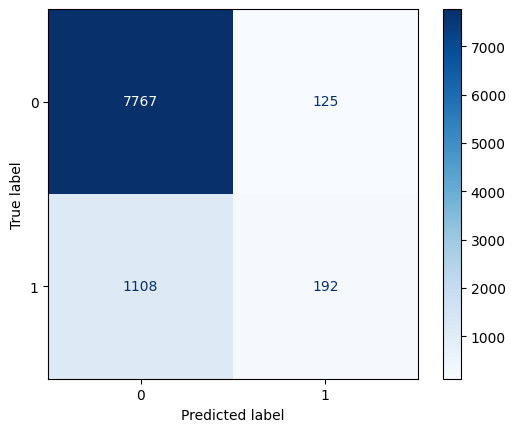

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

features = {"review": g.ndata["feature"]}
logits = model(g, features)["review"]
test_mask = g.ndata["test_mask"].to(bool)
labels = g.ndata["label"][test_mask]
pred = logits.argmax(1)[test_mask]

cm = confusion_matrix(labels, pred)
cm = ConfusionMatrixDisplay(cm)
cm.plot(cmap="Blues")



In [ ]:
import networkx as nx

g = nx.Graph()
e = list(zip([0, 1, 2, 3, 2, 5], [1, 2, 3, 4, 0, 3]))

etype = [0, 1, 2, 0, 1, 2]
print(e)
g.add_edges_from(e)
pos = nx.spring_layout(g)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edge_labels(g, pos, {k: v for k, v in zip(e, etype)})
nx.draw(g, pos)


In [ ]:
import dgl
import numpy as np
import torch as th
from dgl.nn import RelGraphConv
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
feat = th.ones(6, 10)
conv = RelGraphConv(10, 2, 3, regularizer='basis', num_bases=2)
etype = th.tensor([0,1,2,0,1,2])
res = conv(g, feat, etype)
res